In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv("../data/ETTh1.csv")
df['date'] = pd.to_datetime(df['date'])

df['P_high'] = np.sqrt(df['HUFL']**2 + df['HULL']**2)
df['P_mid']  = np.sqrt(df['MUFL']**2 + df['MULL']**2)
df['P_low']  = np.sqrt(df['LUFL']**2 + df['LULL']**2)

In [2]:
def create_windowed_features(df, window_sizes=[6, 12, 24]):
    base_features = ['HUFL','HULL','MUFL','MULL','LUFL','LULL','OT',
                     'P_high','P_mid','P_low']
    results = {}

    for window in window_sizes:
        new_cols = {}

        for feat in base_features:
            roll = df[feat].rolling(window, min_periods=1)
            new_cols[f'{feat}_mean_{window}h'] = roll.mean()
            new_cols[f'{feat}_std_{window}h']  = roll.std().fillna(0)

        df_window = pd.concat([df, pd.DataFrame(new_cols)], axis=1)
        results[window] = df_window.copy()

    return results

windowed_dfs = create_windowed_features(df)

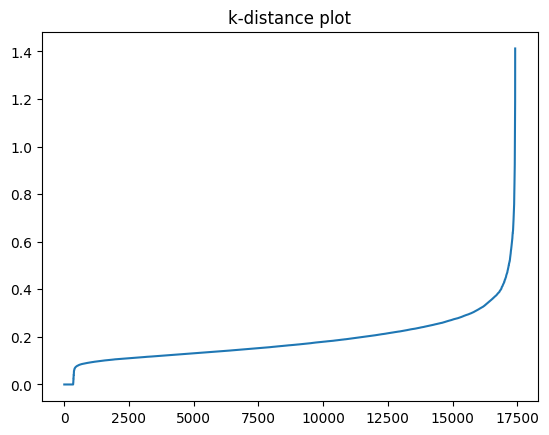

In [3]:
X_eps = df[['P_high','P_mid','P_low','OT']].values
X_eps = StandardScaler().fit_transform(X_eps)

k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(X_eps)
distances, _ = nbrs.kneighbors(X_eps)
k_distances = np.sort(distances[:, k-1])

plt.plot(k_distances)
plt.title("k-distance plot")
plt.show()


The elbow in the k-distance plot provides a heuristic for selecting ε.

In [4]:
# Calculating the ideal value of epsilon

x = np.arange(len(k_distances))
y = k_distances

p1, p2 = np.array([x[0],y[0]]), np.array([x[-1],y[-1]])
dist = np.abs(np.cross(p2-p1, p1-np.vstack((x,y)).T)) / np.linalg.norm(p2-p1)

eps_optimal = k_distances[np.argmax(dist)]
print("Optimal eps:", eps_optimal)


Optimal eps: 0.33062032183972107


In [5]:
def evaluate_window_size(windowed_dfs, eps):
    scores = {}

    for w, dfw in windowed_dfs.items():
        feats = [c for c in dfw.columns if f'_{w}h' in c and 'OT' not in c]
        X = StandardScaler().fit_transform(dfw[feats])

        labels = DBSCAN(eps=eps, min_samples=5).fit_predict(X)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_ratio = np.mean(labels == -1)

        sil = -1
        if n_clusters > 1 and np.sum(labels != -1) > 10:
            sil = silhouette_score(X[labels!=-1], labels[labels!=-1])

        scores[w] = {'labels': labels, 'silhouette': sil}

    best = max(scores, key=lambda k: scores[k]['silhouette'])
    return best, scores

best_window, window_scores = evaluate_window_size(windowed_dfs, eps_optimal)


In [6]:
df_best = windowed_dfs[best_window].copy()
df_best.loc[:, 'cluster'] = window_scores[best_window]['labels']

ridge_features = ['P_high','P_mid','P_low','HUFL','HULL','MUFL','MULL','LUFL','LULL']
X_ridge = StandardScaler().fit_transform(df_best[ridge_features])

reg = Ridge(alpha=1.0)
reg.fit(X_ridge, df_best['OT'])

df_best['OT_pred'] = reg.predict(X_ridge)
df_best['residual'] = df_best['OT'] - df_best['OT_pred']


In [8]:
mae = mean_absolute_error(df_best['OT'], df_best['OT_pred'])
rmse = mean_squared_error(df_best['OT'], df_best['OT_pred'])
r2 = r2_score(df_best['OT'], df_best['OT_pred'])

print("\n==== RIDGE REGRESSION PERFORMANCE ====")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

print("\n==== RESIDUAL STATISTICS ====")
print(df_best['residual'].describe())


==== RIDGE REGRESSION PERFORMANCE ====
MAE  : 6.3684
RMSE : 65.2940
R²   : 0.1103

==== RESIDUAL STATISTICS ====
count    1.742000e+04
mean     8.875666e-16
std      8.080700e+00
min     -6.659884e+01
25%     -6.076144e+00
50%     -1.027696e+00
75%      4.667979e+00
max      3.389059e+01
Name: residual, dtype: float64


In [12]:
median = np.median(df_best['residual'])
mad = np.median(np.abs(df_best['residual'] - median))
mad = max(mad, 1e-6)

res_anomaly = np.abs(df_best['residual'] - median) > 3 * mad

In [13]:
ot_threshold = df_best['OT'].quantile(0.85)

final_anomaly = (
    (df_best['cluster'] == -1) &
    (df_best['OT'] >= ot_threshold) &
    res_anomaly
)


DBSCAN helps detect rare states

Ridge Regression helps detect unexpected responses

The "final_anomaly" basically identifies a rare operating point which also violates expected thermal behavior.

In [15]:
total_points = len(df_best)
dbscan_anoms = np.sum(df_best['cluster'] == -1)
residual_anoms = np.sum(res_anomaly)
final_anoms = np.sum(final_anomaly)

print("\n ANOMALY BREAKDOWN")
print(f"Total samples          : {total_points}")
print(f"DBSCAN anomalies       : {dbscan_anoms} ({dbscan_anoms/total_points:.2%})")
print(f"Residual anomalies     : {residual_anoms} ({residual_anoms/total_points:.2%})")
print(f"Final confirmed        : {final_anoms} ({final_anoms/total_points:.2%})")

print("\nOT THRESHOLD USED ====")
print(f"OT Threshold (85%)     : {ot_threshold:.4f}")



 ANOMALY BREAKDOWN
Total samples          : 17420
DBSCAN anomalies       : 17091 (98.11%)
Residual anomalies     : 922 (5.29%)
Final confirmed        : 892 (5.12%)

OT THRESHOLD USED ====
OT Threshold (85%)     : 21.5260


In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df_best['date'], df_best['OT'])
plt.scatter(df_best.loc[final_anomaly,'date'],
            df_best.loc[final_anomaly,'OT'],
            color='red', s=10)
plt.axhline(ot_threshold, ls='--')
plt.show()


In [ ]:
anomaly_df = df_best.loc[final_anomaly, [
    'date',
    'OT',
    'OT_pred',
    'residual',
    'P_high',
    'P_mid',
    'P_low',
    'cluster'
]].copy()

anomaly_df['abs_residual'] = anomaly_df['residual'].abs()

anomaly_df.to_csv("detected_anomalies.csv", index=False)